<a href="https://colab.research.google.com/github/khairulniza/MANB2153/blob/master/Term_Paper_Pneumonia_Detection_Using_CNN_(with_imbalanced_data_handling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive




---



In [2]:
#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import fnmatch
import keras
from time import sleep
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k
import os



Using TensorFlow backend.


In [3]:
#import os
#import cv2
#import glob
import h5py
import shutil

import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from skimage.io import imread
#from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from keras.layers import Input, Flatten, SeparableConv2D, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

from keras import backend as K
import tensorflow as tf
print(os.listdir("gdrive/My Drive/Chest xray"))


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

['test', 'train', 'val']


In [0]:
data_dir = Path('gdrive/My Drive/Chest xray')
# path to directory containing train set
train_dir = data_dir / 'train'

# path to directory containing validation set
val_dir = data_dir / 'val'

# path to the directory containing test set
test_dir = data_dir / 'test'

In [5]:
normal_train = train_dir / 'NORMAL'
pneumonia_train = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_train.glob('*.jpeg')
pneumonia_cases = pneumonia_train.glob('*.jpeg')

train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_df.append((str(img),0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_df.append((str(img), 1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_df.head()

,image,label
0,gdrive/My Drive/Chest xray/train/PNEUMONIA/per...,1
1,gdrive/My Drive/Chest xray/train/NORMAL/NORMAL...,0
2,gdrive/My Drive/Chest xray/train/PNEUMONIA/per...,1
3,gdrive/My Drive/Chest xray/train/NORMAL/IM-045...,0
4,gdrive/My Drive/Chest xray/train/NORMAL/NORMAL...,0


1    3875
0    1341
Name: label, dtype: int64


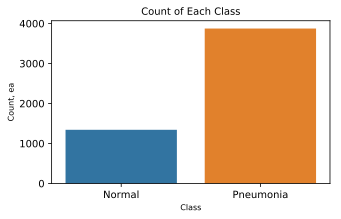

In [6]:
# Get the counts for each class
cases_count = train_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,3))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Count of Each Class', fontsize=10)
plt.xlabel('Class', fontsize=8)
plt.ylabel('Count, ea', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

1    390
0    234
Name: label, dtype: int64


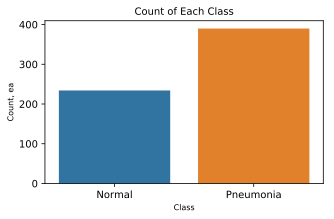

In [7]:
normal_test = test_dir / 'NORMAL'
pneumonia_test = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_test.glob('*.jpeg')
pneumonia_cases = pneumonia_test.glob('*.jpeg')

test_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_df.append((str(img),0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_df.append((str(img), 1))

# Get a pandas dataframe from the data we have in our list 
test_df = pd.DataFrame(test_df, columns=['image', 'label'],index=None)

# Shuffle the data 
test_df = test_df.sample(frac=1.).reset_index(drop=True)

# Get the counts for each class
cases_count = test_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,3))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Count of Each Class', fontsize=10)
plt.xlabel('Class', fontsize=8)
plt.ylabel('Count, ea', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

1    8
0    8
Name: label, dtype: int64


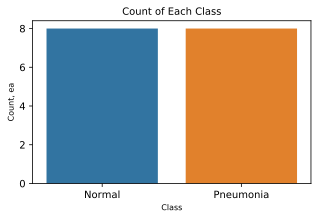

In [8]:
normal_val = val_dir / 'NORMAL'
pneumonia_val = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_val.glob('*.jpeg')
pneumonia_cases = pneumonia_val.glob('*.jpeg')

val_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    val_df.append((str(img),0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    val_df.append((str(img), 1))

# Get a pandas dataframe from the data we have in our list 
val_df = pd.DataFrame(val_df, columns=['image', 'label'],index=None)

# Shuffle the data 
val_df = val_df.sample(frac=1.).reset_index(drop=True)

# Get the counts for each class
cases_count = val_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,3))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Count of Each Class', fontsize=10)
plt.xlabel('Class', fontsize=8)
plt.ylabel('Count, ea', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

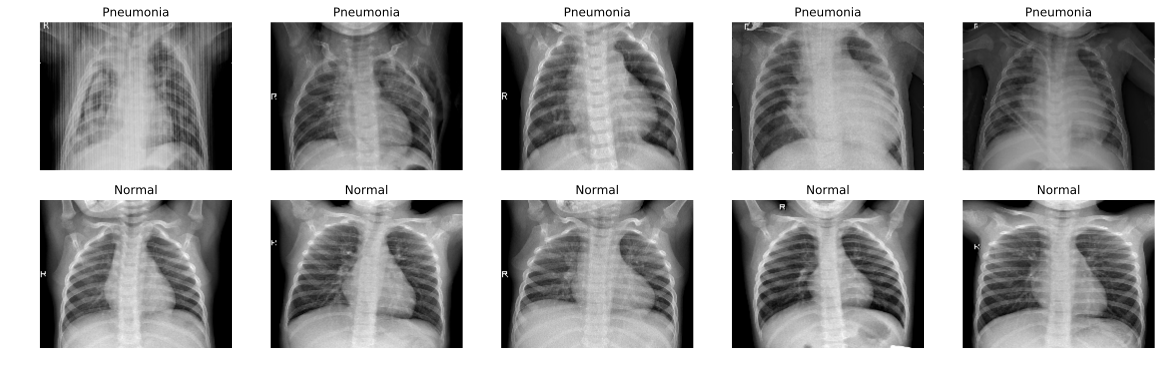

In [9]:
# Some samples for both the classes
pneumonia_samples = (train_df[train_df['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(20,6))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()



---


Using keras and sklearn

In [13]:
print(os.listdir("gdrive/My Drive/Chest xray/val/PNEUMONIA"))

['.DS_Store', 'person1946_bacteria_4874.jpeg', 'person1950_bacteria_4881.jpeg', 'person1947_bacteria_4876.jpeg', 'person1946_bacteria_4875.jpeg', 'person1949_bacteria_4880.jpeg', 'person1951_bacteria_4882.jpeg', 'person1952_bacteria_4883.jpeg', 'person1954_bacteria_4886.jpeg']


In [14]:
image_patch = glob('gdrive/My Drive/Chest xray/**/**/*.jpeg', recursive=True)
print(len(image_patch))

17568


In [0]:
pattern_normal = '*NORMAL*'
pattern_bacteria = '*_bacteria_*'
pattern_virus = '*_virus_*'

normal = fnmatch.filter(image_patch, pattern_normal)
bacteria = fnmatch.filter(image_patch, pattern_bacteria)
virus = fnmatch.filter(image_patch, pattern_virus)
x = []
y = []
for img in image_patch:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    if img in normal:
        y.append(0)
    elif img in bacteria:
        y.append(1)
    elif img in virus:
        y.append(1)
    else:
        print('no class')
x = np.array(x)
y = np.array(y)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.30, random_state = 100)

In [17]:
x_train.shape

(12297, 224, 224, 3)

In [18]:
x_valid.shape

(5271, 224, 224, 3)

In [0]:
# Deal with imbalanced class sizes below
X_trainShape = x_train.shape[1]*x_train.shape[2]*x_train.shape[3]
X_validShape = x_valid.shape[1]*x_valid.shape[2]*x_valid.shape[3]
X_trainFlat = x_train.reshape(x_train.shape[0], X_trainShape)
X_validFlat = x_valid.reshape(x_valid.shape[0], X_validShape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, y_train)
X_testRos, Y_testRos = ros.fit_sample(X_validFlat, y_valid)




In [21]:
#Distribution value (old) and (new)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.8310006  0.68782862]
New Class Weights:  [1. 1.]




---


In [0]:
y_trainHot = to_categorical(y_train, num_classes = 2)
y_validHot = to_categorical(y_valid, num_classes = 2)

In [0]:
a = x_train
b = y_trainHot
c = x_valid
d = y_validHot

In [24]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU 

model = Sequential()
model.add(Conv2D(32,(7,7),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(GlobalAveragePooling2D())
model.add(Dense(1000, activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='model_check_path.hdf5',monitor="val_acc", save_best_only=True, mode='max')
callbacks_list=[mcp]
hist = model.fit(a,b,batch_size = 4, epochs = 10, verbose=1,validation_data = [c, d],  validation_split=0.3, callbacks=[mcp])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 12297 samples, validate on 5271 samples
Epoch 1/10
12297/12297 [==============================] - 61s 5ms/step - loss: 0.3360 - acc: 0.8504 - val_loss: 0.1893 - val_acc: 0.9234
Epoch 2/10
12297/12297 [==============================] - 59s 5ms/step - loss: 0.2627 - acc: 0.8896 - val_loss: 0.3303 - val_acc: 0.8570
Epoch 3/10
12297/12297 [==============================] - 58s 5ms/step - loss: 0.2110 - acc: 0.9192 - val_loss: 0.2207 - val_acc: 0.9086
Epoch 4/10
12297/12297 [==============================] - 59s 5ms/step - loss: 0.1890 - acc: 0.9268 - val_loss: 0.3698 - val_acc: 0.8456
Epoch 5/10
12297/12297 [==============================] - 59s 5ms/step - loss: 0.1695 - acc: 0.9388 - val_loss: 0.2792 - val_acc: 0.8805
Epoch 6/10
12297/12297 [==============================] - 58s 5ms/step - loss: 0.1587 - acc: 0.9394 - v

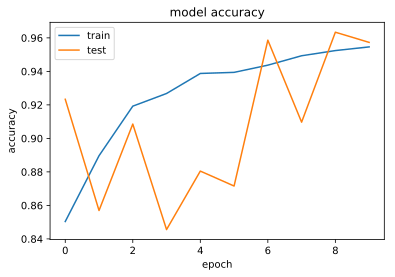

In [30]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

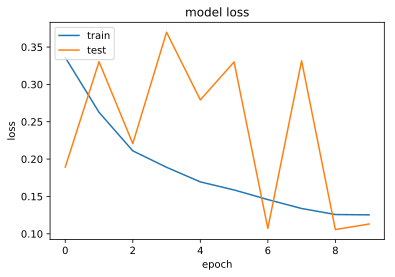

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



---



In [0]:
y_pred = model.predict(c)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(d,axis=1)

In [33]:
from sklearn.metrics import classification_report
pred = model.predict(c)
print(classification_report(np.argmax(d, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1391
           1       0.99      0.95      0.97      3880

    accuracy                           0.96      5271
   macro avg       0.94      0.96      0.95      5271
weighted avg       0.96      0.96      0.96      5271



Note:
- Macro average (averaging the unweighted mean per label).
- Weighted average (averaging the support-weighted mean per label)

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

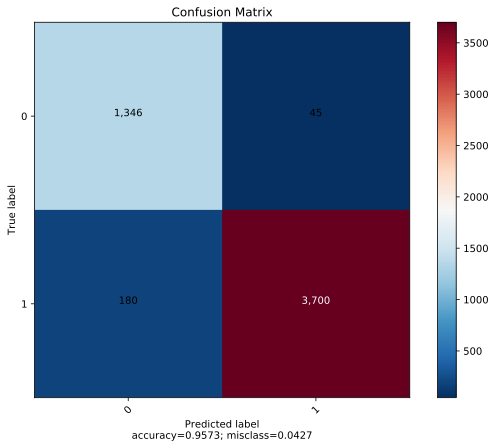

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(d, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='RdBu_r',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")